In [1]:
import kwant
import kwant.continuum
import matplotlib.pyplot as plt
import numpy as np
import tinyarray

C:\Users\HASAN\Anaconda3\envs\kwant\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [2]:
a=1  # lattice constant

hamiltonian = """( M + V_sl(x,y) + B*(k_x**2+k_y**2)) * sigma_z + A * (k_x*sigma_x + k_y*sigma_y)"""
template = kwant.continuum.discretize(hamiltonian,grid=a)

Lx=4000
Ly=30

d1=20
d2=20
V1=0.6
V2=-0.6
xperiod=d1+d2

def rectangular(site):
    (x, y) = site.pos
    return (0 <= x < Lx and 0 <= y < Ly)

def lead_shape(site):
    (x, y) = site.pos
    return (0 <= y < Ly)

syst = kwant.Builder()
syst.fill(template, rectangular, (0, 0))

lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead.fill(template, lead_shape, (0, 0))

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

In [3]:
%%time
def heaviside(d1,xmod,y):
    if xmod<d1:
        return V1
    else:
        return V2
def super_lattice(x,y):
    if 0<= y <Ly:
        return heaviside(d1, (x)%xperiod,y)

# Now that we have the system, we can compute conductance
params=dict(A = 1, B = 1, M = -2, V_sl=super_lattice)

Wall time: 0 ns


1000.step

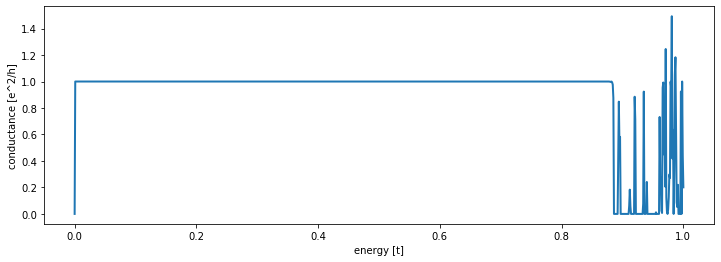

Wall time: 2h 9min 12s


In [4]:
%%time
trans10 = []
NE=1001
energy=np.linspace(0.,1,NE)

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i], params=params)
    print(f'\r{i}.step', end='', flush=True)
    trans10.append(smatrix.transmission(1, 0))

plt.figure(figsize=(12,4))
plt.plot(energy,trans10,'-',lw=2)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

In [5]:
np.savetxt('data/qah_cond_data_W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.txt'.format(Ly, Lx, V1, V2, d1, d2, NE),
           [energy,trans10],fmt='%.18e')

In [6]:
%%time
def lead_system(template):
    xperiod=d1+d2
    def lead_shape(site): 
        (x, y) = site.pos
        return (0 <= y < Ly)

    lead = kwant.Builder(kwant.TranslationalSymmetry([-xperiod, 0]))
    lead.fill(template, lead_shape, (0, 0))
    syst = lead.finalized()
    
    return syst

lead_syst=lead_system(template)

#band structure
bands = kwant.physics.Bands(lead_syst, params=params)
momenta = np.linspace(-np.pi, np.pi, 101)
energies = [bands(k) for k in momenta]

Wall time: 3min 22s


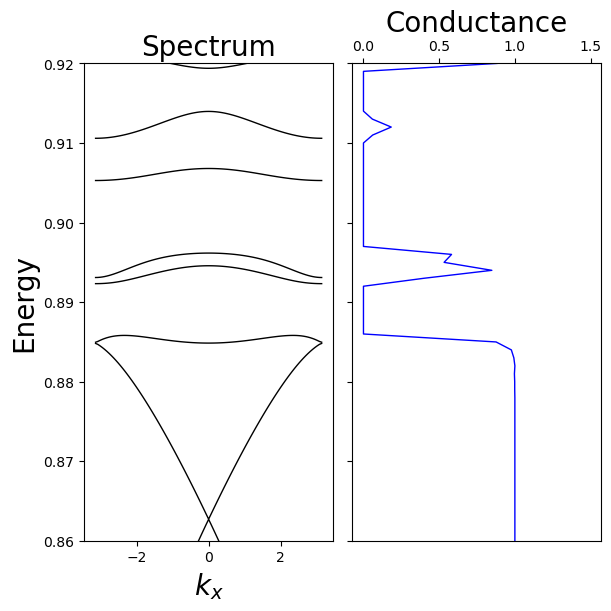

In [8]:
fig, ax = plt.subplots(1, 2, dpi=100, sharey=True, figsize=(6,6), constrained_layout=True)
#NE=3001
#Lx=200

ax[0].plot(momenta, np.array(energies),'-k',lw=1)
ax[0].set_title('Spectrum',fontsize=20)
ax[0].set_xlabel('$k_x$', fontsize=20)
ax[0].set_ylabel('Energy', fontsize=20)

energy,trans10=np.loadtxt('data\qah_cond_data_W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.txt'.format(Ly, Lx, V1, V2, d1, d2, NE))
ax[1].plot(np.array(trans10),energy,'-b',lw=1)
#ax[1].plot(np.ones(NE),np.linspace(0,1,NE),'-b',lw=1)
ax[1].set_title('Conductance',fontsize=20)
ax[1].set_ylim(0.86,0.92)
ax[1].xaxis.set_ticks_position('top')
plt.savefig('figs\qah_spec_cond_zoomed_W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.png'.format(Ly, Lx, V1, V2, d1, d2, NE))

In [15]:
np.shape(energy)

(1001,)

In [28]:
%%time
def lead_system(template):
    xperiod=d1+d2
    def lead_shape(site): 
        (x, y) = site.pos
        return (0 <= y < Ly)

    lead = kwant.Builder(kwant.TranslationalSymmetry([-xperiod, 0]))
    lead.fill(template, lead_shape, (0, 0))
    syst = lead.finalized()
    
    return syst

lead_syst=lead_system(template)

#band structure
bands = kwant.physics.Bands(lead_syst, params=params)
momenta = np.linspace(-np.pi, np.pi, 51)
energies = [bands(k) for k in momenta]

Wall time: 1min 36s


(0.88, 0.92)

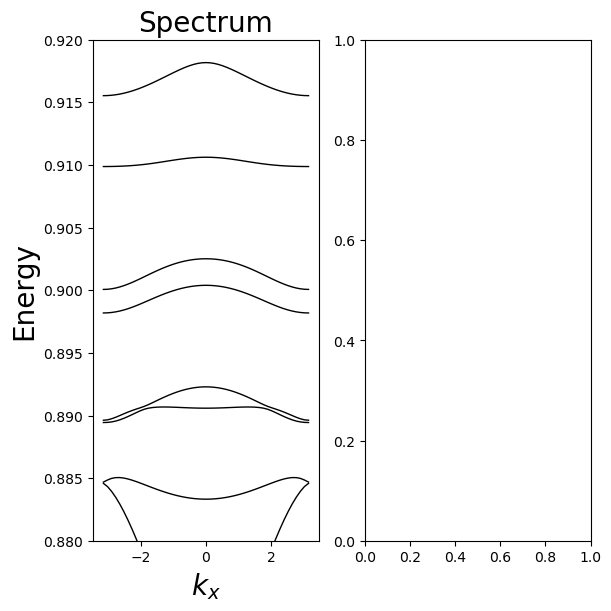

In [33]:
fig, ax = plt.subplots(1, 2, dpi=100, sharey=False, figsize=(6,6), constrained_layout=True)
#NE=101
#Lx=200
ax[0].plot(momenta, np.array(energies),'-k',lw=1)
ax[0].set_title('Spectrum',fontsize=20)
ax[0].set_xlabel('$k_x$', fontsize=20)
ax[0].set_ylabel('Energy', fontsize=20)
ax[0].set_ylim(0.88,0.92)

#energy,trans10=np.loadtxt('data\qah_cond_data_W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.txt'.format(Ly, Lx, V1, V2, d1, d2, NE))
#ax[1].plot(np.array(trans10),energy,'-b',lw=1)
#ax[1].set_title('Conductance',fontsize=20)
#ax[1].set_xlim(0.,1.1)
#ax[1].xaxis.set_ticks_position('top')
#plt.savefig('figs\qah_spec_cond_W={0}_L={1}_V1={2:.3f}_V2={3:.3f}_d1={4}_d2={5}_NE={6}.png'.format(Ly, Lx, V1, V2, d1, d2, NE))